

```
# Выбран кодовый формат
```

## ДЗ 3 
Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на губы
И затем обучить Модель на выбор из segmentation_models_pytorch


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from google.colab import drive


from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import torch.nn as nn
from pathlib import Path


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
read_img = '/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/'
read_mask = '/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/'


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/list.csv', delimiter=',')
df1.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
read_img = []
read_mask = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/'):
    for name in files:
        f = os.path.join(root, name)
        if 'images' in f:
            read_img.append(f)
        elif 'mask' in f:
            read_mask.append(f)
        else:
            break



In [ ]:
pd.set_option('display.max_colwidth', -1)
mask = pd.DataFrame(read_mask, columns = ['mask'])
mask['ind'] = mask['mask'].replace(regex = True, to_replace = '.*\\\\' , value = '').replace(regex = True, to_replace = '\D' , value = '')
#mask = mask.set_index('ind')
mask


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,mask,ind
0,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000027.png,00000027
1,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000024.png,00000024
2,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000025.png,00000025
3,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000023.png,00000023
4,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000030.png,00000030
...,...,...
6704,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00006666.png,00006666
6705,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00006675.png,00006675
6706,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00006674.png,00006674
6707,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00006665.png,00006665


In [ ]:
lips = pd.DataFrame(read_img , columns = ['lips'])
lips['ind'] = lips['lips'].replace(regex = True, to_replace = '.*\\\\' , value = '').replace(regex = True, to_replace = '\D' , value = '')
#lips.set_index('ind')
lips

,lips,ind
0,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00027049.jpg,00027049
1,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00027253.jpg,00027253
2,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00027087.jpg,00027087
3,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00027320.jpg,00027320
4,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00027083.jpg,00027083
...,...,...
28065,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000066.jpg,00000066
28066,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000062.jpg,00000062
28067,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000079.jpg,00000079
28068,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000068.jpg,00000068


In [ ]:
df = lips.merge(mask).drop(['ind'], axis = 1)
# Отсортируем  датафрейм по значениям
df.sort_values(by='lips',inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)

,lips,mask
0,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000001.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000001.png
1,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000002.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000002.png
2,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000003.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000003.png
3,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000004.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000004.png
4,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000005.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000005.png


In [ ]:
df = df[:3000] # сократим количество примеров для ускорения
df

,lips,mask
0,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000001.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000001.png
1,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000002.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000002.png
2,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000003.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000003.png
3,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000004.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000004.png
4,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000005.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000005.png
...,...,...
2995,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00002996.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00002996.png
2996,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00002997.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00002997.png
2997,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00002998.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00002998.png
2998,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00002999.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00002999.png


In [ ]:
def img_to_bin(read_path, write_path):
    img = cv2.cvtColor(cv2.imread(str(read_path)), cv2.COLOR_BGR2RGB)

    height, width, channels = img.shape
    img_binary = np.zeros((height,width,1))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
    (thresh, img_binary) = cv2.threshold(img_grayscale, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_binary = cv2.bitwise_not(img_binary) #invert img
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, img_binary)
    return new_path





In [ ]:
new_paths = []
bin_path = Path('/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/')
for index, row in df.iterrows():
  new_path = img_to_bin(Path(row['mask']), bin_path)
  new_paths.append(new_path)
df['mask_bin'] = new_paths
df.head()


,lips,mask,mask_bin
0,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000001.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000001.png,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000001.png
1,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000002.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000002.png,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000002.png
2,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000003.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000003.png,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000003.png
3,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000004.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000004.png,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000004.png
4,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/images/image00000005.jpg,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask/mask00000005.png,/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000005.png


In [5]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/path_lips.csv', index = False)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/path_lips.csv")

In [6]:
labels = [ 'Lips']

[  0 255]


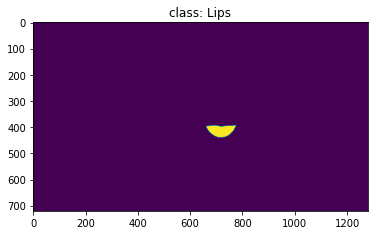

In [7]:
for i in range(1):
    mask = plt.imread('/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/mask_inverted/mask00000042.png')*255
    mask = np.where(mask == i, 255, 0)
#     mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [8]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,2]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256, 256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))*255

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')

        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)

#         mask = mask.view(mask.shape[0], mask.shape[1], 1)
#         mask = torch.FloatTensor(mask[None,].type(torch.float32))
#         print(mask.size())
        # Размерность каналов на передний план
        mask = mask.permute(2, 0, 1)

        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0)
#         print(mask.size())

        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [9]:
from sklearn.model_selection import train_test_split

#labels = [ 'Unlabeled','Lips']

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)



In [10]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 245kB 10.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=d6c754a533a981919e7bb34fac024a29b196f1cc8cecdb1a6299555c51ccf4db
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=ce453fb36b0cd4b8f97e2854c917b097ea0157645532dba2e95698e52a7d33c8
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [14]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights = 'imagenet', classes=1, activation='sigmoid').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 2):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['fscore']:
#         max_score = valid_logs['fscore']
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')




Epoch: 0
valid: 100%|██████████| 180/180 [11:44<00:00,  3.91s/it, dice_loss - 0.03952, iou_score - 0.9365]
Model saved!

Epoch: 1
valid: 100%|██████████| 180/180 [05:49<00:00,  1.94s/it, dice_loss - 0.03186, iou_score - 0.9436]
Model saved!


In [15]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

In [21]:
 torch.save(segmodel, '/content/drive/MyDrive/Colab Notebooks/data/set-lipstick-original/seg_model.pth')
# segmodel = torch.load('./seg_model.pth')

TypeError: ignored

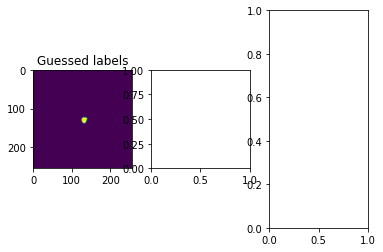

In [22]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,5):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels[j].permute(1, 2, 0).detach().cpu().numpy())
        axarr[1].set_title('Ground truth labels')

        original = images[j].cpu().permute(1, 2, 0)
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
    if i>5:
        break

In [ ]:
import time
from torch.autograd import Variable
from sklearn.metrics import jaccard_similarity_score as jsc
import segmentation_models_pytorch as smp

In [ ]:
### TEST